In [1]:
# library 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

In [27]:
# 데이터 불러오기
df = pd.read_csv('train_V2.csv')

In [28]:
# Data shape(형태) 출력
# Row : 4446966, Column : 29
df.shape

(4446966, 29)

In [29]:
# Null값 확인
# winPlacePerc가 결측인 행이 하나 존재한다.
df.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [30]:
# 결측 행이 많지 않으므로 삭제하는 것으로 진행하였다.
df = df.dropna()
df.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
dtype: int64

## **EDA**

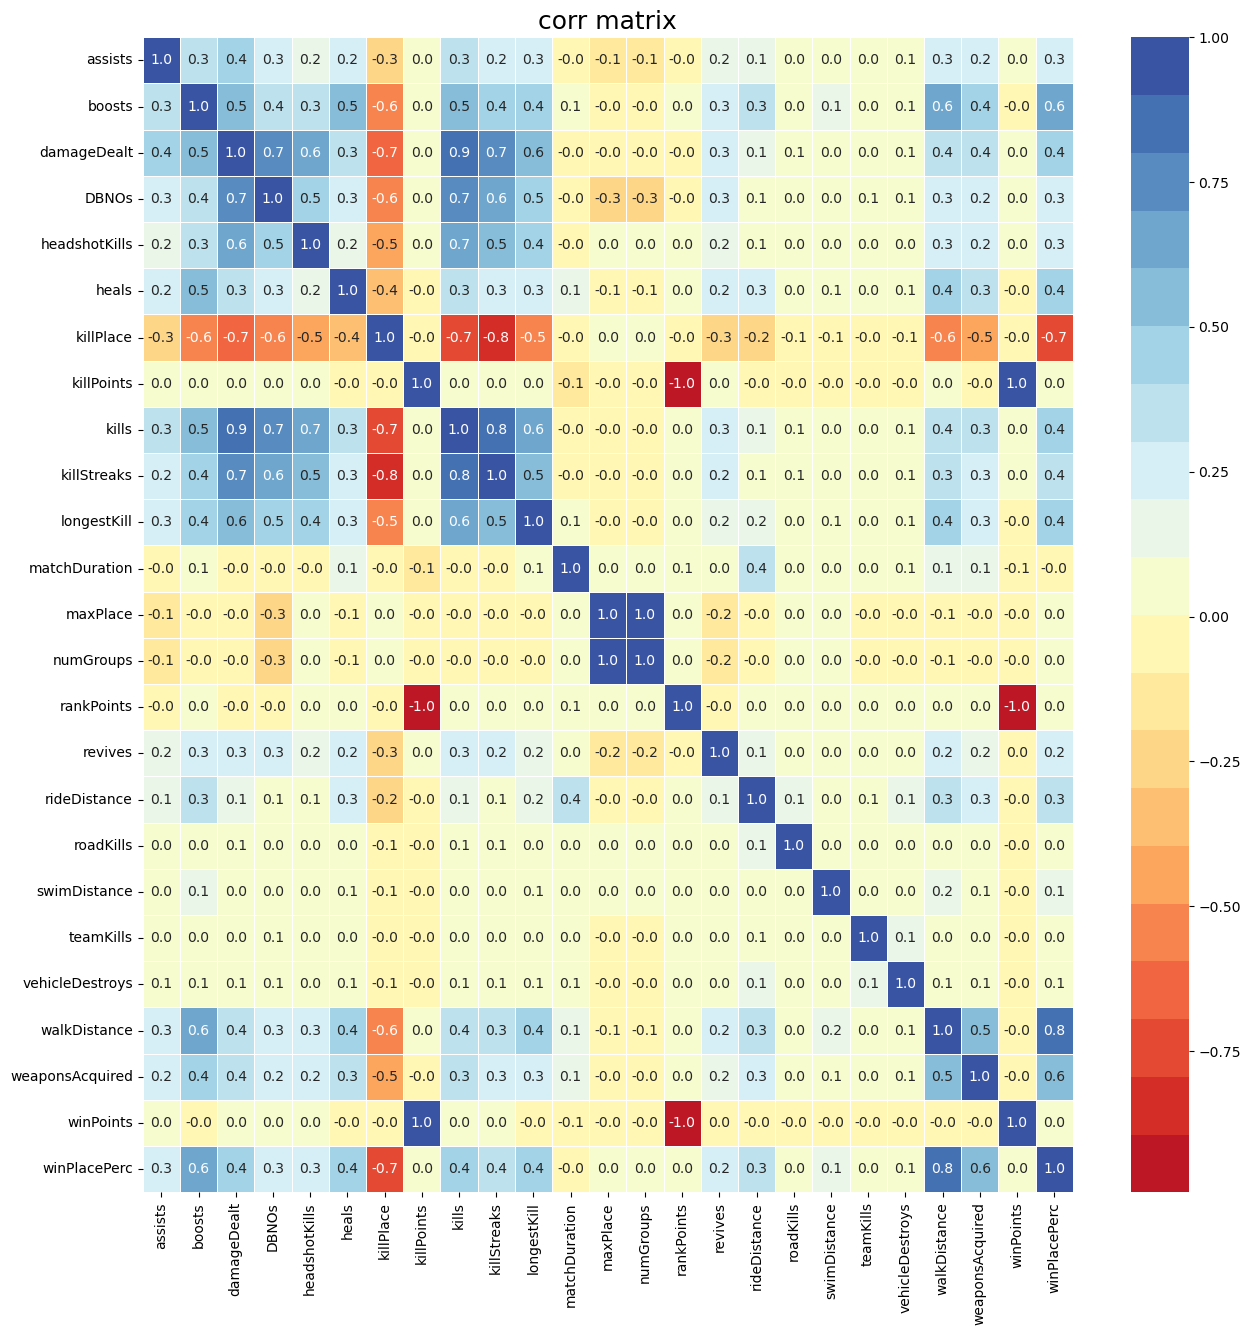

In [34]:
# 상관계수 확인해보기
f,ax = plt.subplots(figsize=(15, 15))

#corr 
sns.heatmap(df.corr(numeric_only=True), annot=True, linewidths=.5, fmt= '.1f',ax=ax, cmap=sns.color_palette("RdYlBu", 20))
ax.set_title('corr matrix', size=18, color="black")

plt.show()

In [36]:
# 매치 타입 확인해보기
map_df = df.matchType.value_counts().to_frame().reset_index()
map_df.head()

,matchType,count
0,squad-fpp,1756186
1,duo-fpp,996691
2,squad,626526
3,solo-fpp,536761
4,duo,313591


<Axes: xlabel='matchType', ylabel='count'>

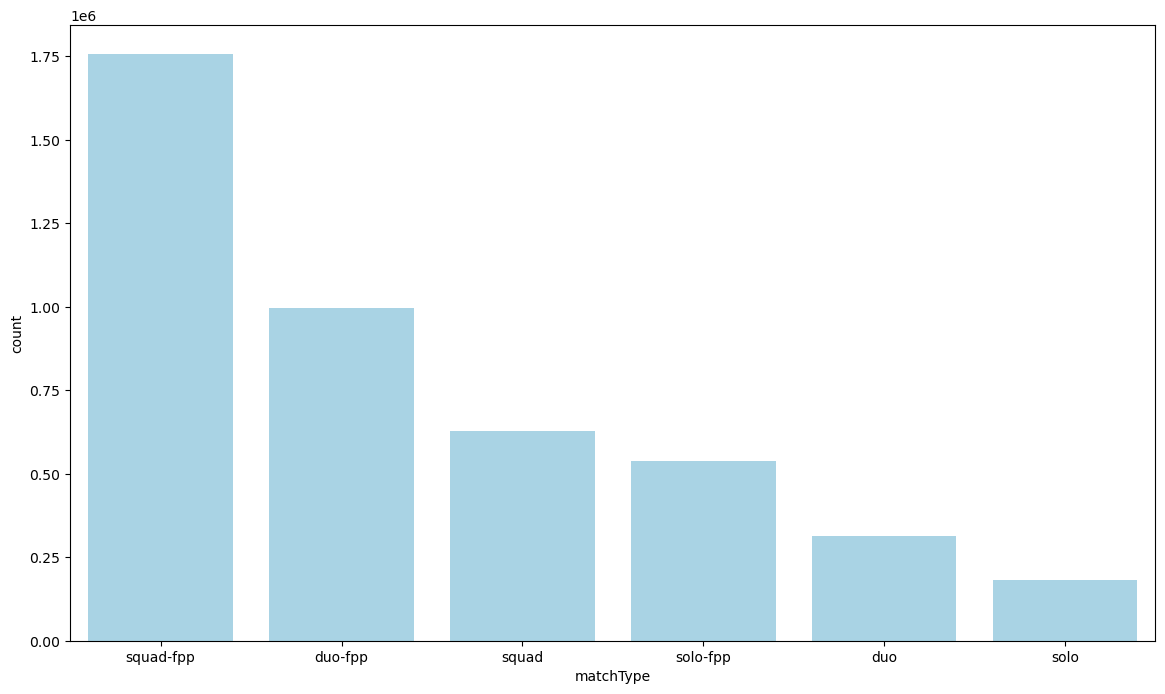

In [51]:
# 매치 타입 시각화
# squad-fpp 모드가 제일 많고, duo-fpp, squad 순으로 나타났다
plt.figure(figsize=(14,8))
sns.barplot(x=map_df['matchType'][:6], y=map_data['count'], alpha=0.8, color='skyblue')

Text(0, 0.5, 'count')

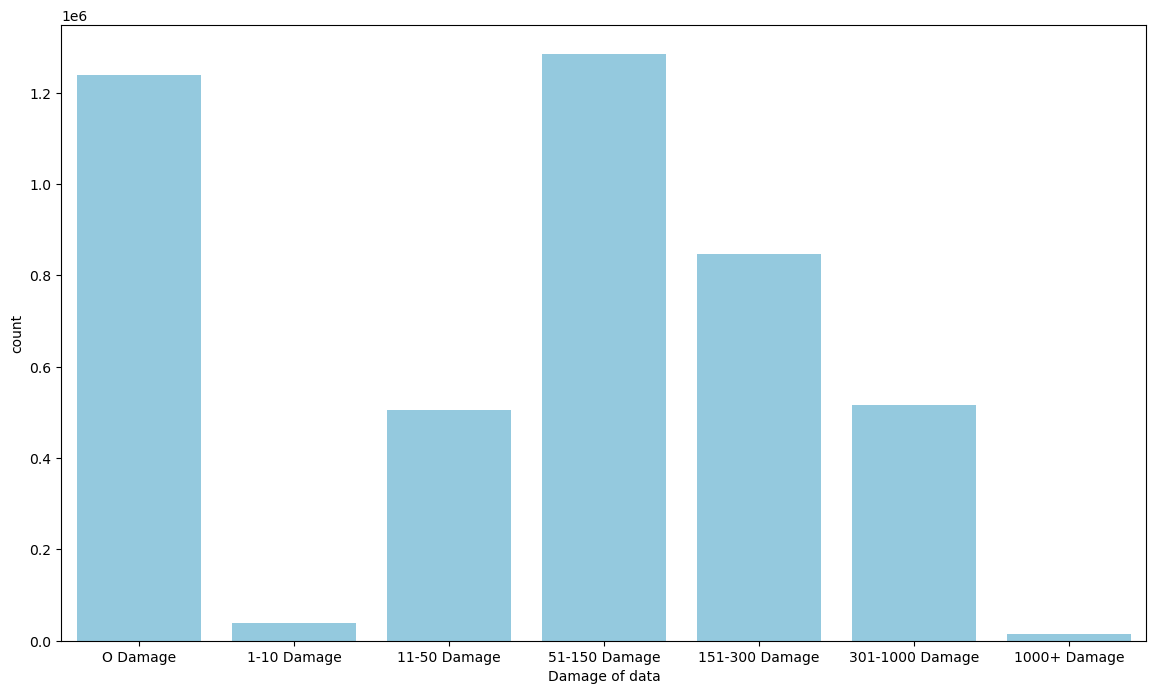

In [62]:
# 가한 데미지 범주화 
df['Category_dealt'] = pd.cut(df['damageDealt'], [-1, 0, 10, 50, 150, 300, 1000, 6000],
      labels = ['O Damage', '1-10 Damage', '11-50 Damage', '51-150 Damage', '151-300 Damage', '301-1000 Damage', '1000+ Damage'])

# 시각화
# 많은 유저가 데미지를 넣지 못하고 게임을 끝냈으며 대부분 51~150 정도의 데미지를 넣은 것으로 확인됐다.
plt.figure(figsize=(14, 8))
sns.countplot(x = df['Category_dealt'], color='skyblue')
plt.xlabel("Damage of data")
plt.ylabel("count")

Text(0.5, 1.0, 'distribuion of winplaceperc by distance')

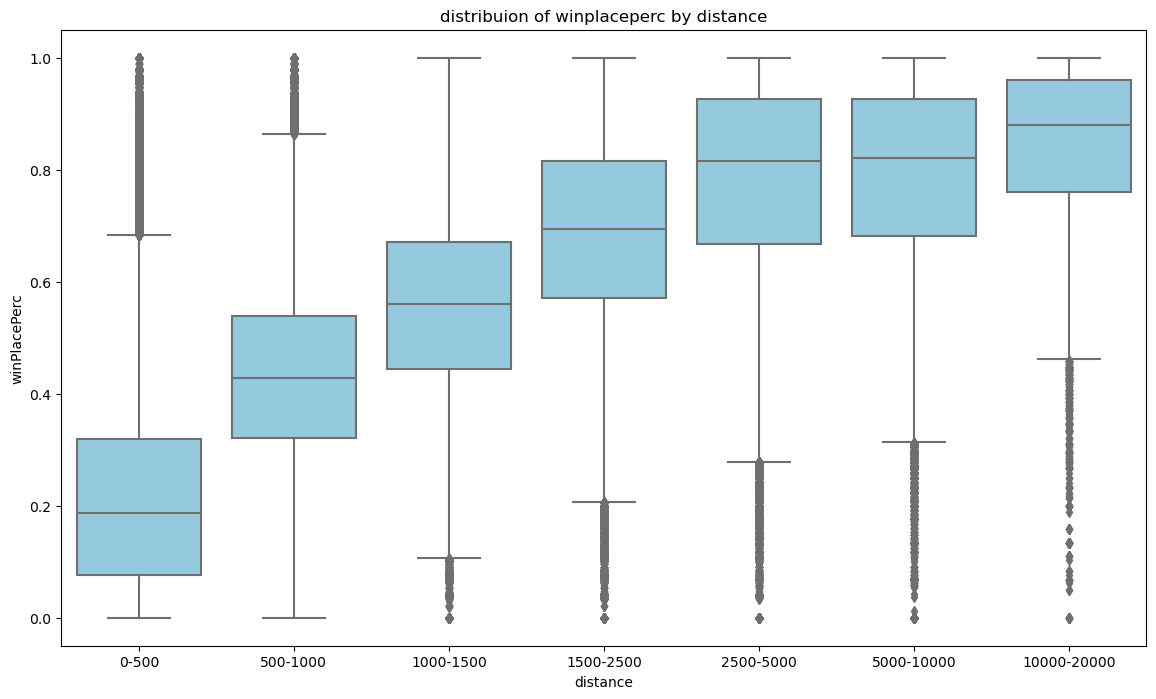

In [66]:
# 거리에 따른 승률의 차이가 있을까?
# 총 거리 계산
df['total_distance'] = df['walkDistance'] + df['rideDistance'] + df['swimDistance']

# 거리를 범주화하기
df['category_distance'] = pd.cut(df['total_distance'], [0, 500, 1000, 1500, 2500, 5000, 10000, 20000],
      labels = ['0-500', '500-1000', '1000-1500', '1500-2500', '2500-5000', '5000-10000','10000-20000'])

# 시각화
# 대체적으로 이동 거리가 클수록 승률이 높아지는 경향이 있는 것으로 보인다.
# 이는 끝까지 살아남기 위해서는 자기장에 따라 끊임없이 이동해야하기 때문인 것으로 판단된다.
plt.figure(figsize=(14, 8))
sns.boxplot(x='category_distance', y='winPlacePerc', data=df, color='skyblue')
plt.xlabel("distance")
plt.ylabel("winPlacePerc")
plt.title('distribuion of winplaceperc by distance')

## **이상 데이터 탐지**   
**┗ 이상 데이터 정의**
```
[가설]
- 먼 거리에서 헤드샷 킬의 비율이 100%인 유저가 존재할까?
- 힐/부스팅을 사용하지 않고 킬을 많이 하는 유저가 존재할까?
- 이동하지 않고 무기를 많이 획득한 유저가 존재할까?
```

1. 먼 거리에서 헤드샷 킬의 비율이 100%인 유저가 존재할까?

In [67]:
# 헤드샷 비율 변수 계산
df['headshot_rate'] = df['headshotKills'] / df['kills']

# 0킬인 경우, 결측값으로 계산되므로 0으로 변환
df.loc[df['kills']==0, 'headshot_rate'] = 0

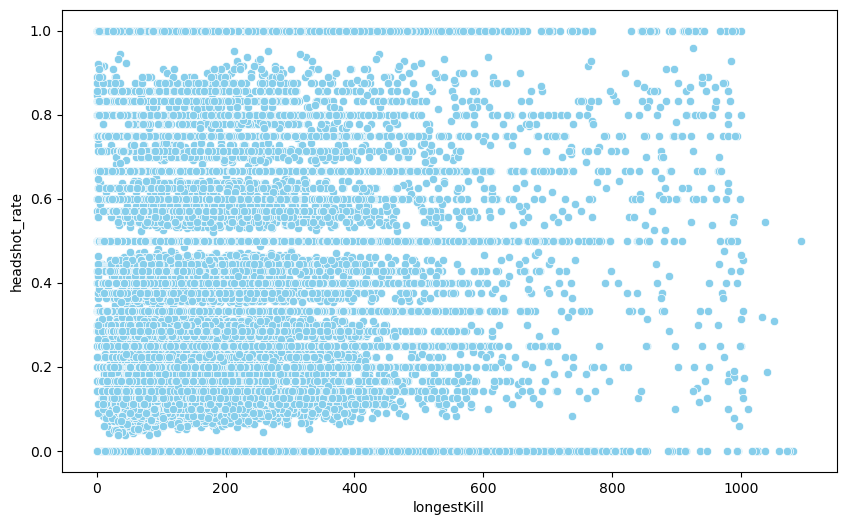

In [73]:
# 거리와 헤드샷 비율 분포 확인
plt.figure(figsize=(10,6))
sns.scatterplot(x='longestKill', y='headshot_rate', data=df, color="skyblue");

킬을 한 거리가 400이 넘어가는데도 헤드샷 비율이 1인 유저가 존재하였다.   
그러나 해당 유저의 총 킬수가 1킬일 수도 있으므로 7킬 이상(상위 1%)인 유저들만 따로 뽑아서 분석해보았다.

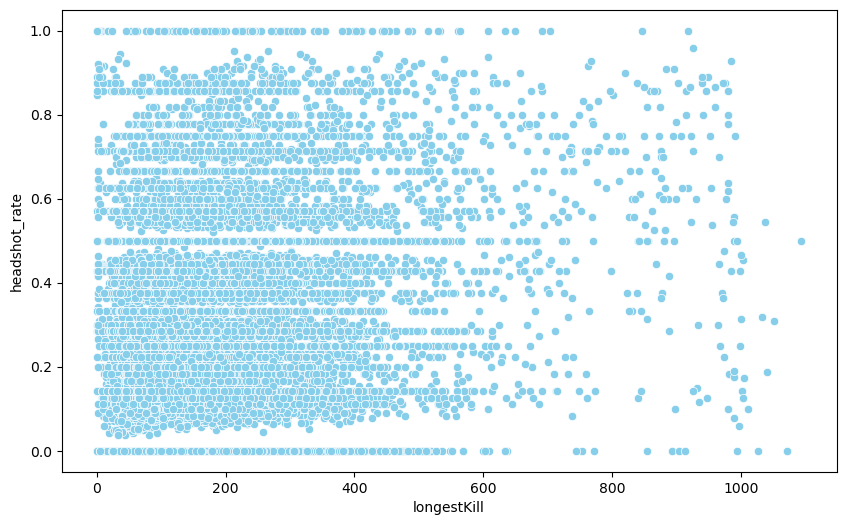

In [74]:
# kill >= 7인 유저들만 따로 추출
upper_7kill = df[df['kills']>=7].copy()

# 거리와 헤드샷 비율 분포 확인
plt.figure(figsize=(10,6))
sns.scatterplot(x='longestKill',y='headshot_rate', data=upper_7kill, color="skyblue");

5킬 이상인 유저들 중에서도 먼 거리에서도 헤드샷킬 비율이 1인 유저들을 확인할 수 있었다.   
해당 유저들은 핵 사용 유저로 의심해볼 수 있다.

In [76]:
# 유저 추출(25명)
upper_7kill.loc[(upper_7kill['longestKill']>=400) & (upper_7kill['headshot_rate']==1), ['Id', 'longestKill']].reset_index(drop=True)

,Id,longestKill
0,1a23298ecdb19d,443.5
1,044d18fc42fc75,633.6
2,29e1798150ef6e,400.1
3,b71eb6abca7242,412.1
4,fffa75359355e1,452.8
5,691efb2af37a7a,409.9
6,566d8218b705aa,533.2
7,99edc8d9bc8f88,691.0
8,1c245ed99b5f96,484.9
9,300e40d77c92d2,560.6


2. 힐/부스팅을 사용하지 않고 킬을 많이 하는 유저가 존재할까?

count    4.446965e+06
mean     2.477055e+00
std      3.879985e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      4.000000e+00
max      8.100000e+01
Name: healboost, dtype: float64


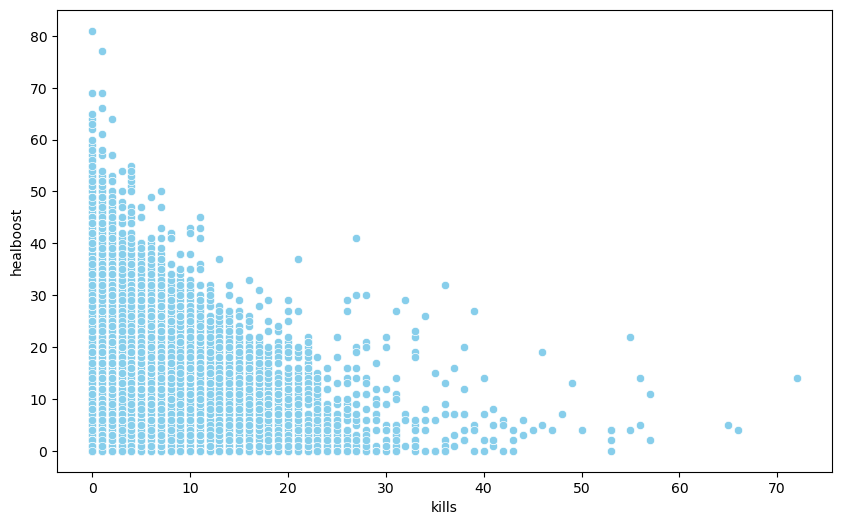

In [80]:
# 힐/부스팅 아이템 총 사용횟수 변수 생성
df['healboost'] = df['heals'] + df['boosts']

# 분포 확인
print(df['healboost'].describe())

# 그래프 확인
plt.figure(figsize=(10,6))
sns.scatterplot(x='kills',y='healboost', data=df, color="skyblue");

heal/boost 사용 수가 0인데 킬 수가 많은 유저들이 존재하였다.   
heal/boost 사용 수가 0이면서 7킬 이상인 유저들 추출해보았다.

In [81]:
# 유저들 추출(1393명)
upper_7kill = df[df['kills']>=7].copy()
upper_7kill.loc[(upper_7kill['healboost']==0), ['Id', 'kills']].reset_index(drop=True)

,Id,kills
0,dd405460138cf2,9
1,3b5d06b8d5b8e9,13
2,e17aabeb0af04d,14
3,ef706f0f248dbf,24
4,5983e465259215,18
...,...,...
1388,b9380daebc8eb3,7
1389,f63bd3f6a044e0,7
1390,2b14db2dfdd5bf,9
1391,9e6d286d16f483,8


다른 가설들에 비해 많은 유저 수가 확인되었다.   
따라서 킬수의 threshold의 값을 높이거나, 다른 변수들과 함께 확인해보는 추가적인 분석이 필요하다.

3. 이동하지 않고 무기를 많이 획득한 유저가 존재할까?

<Axes: xlabel='total_distance', ylabel='weaponsAcquired'>

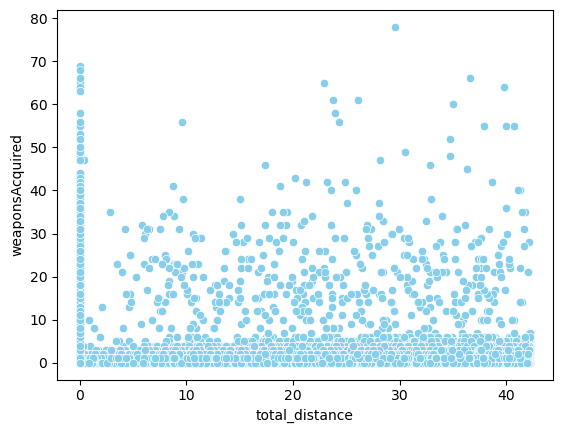

In [85]:
# total_distance가 하위 10%인 data set 생성
under10_distance = df[df['total_distance'] <= df['total_distance'].quantile(0.1)]

# 산점도를 통해 데이터 확인
sns.scatterplot(x='total_distance',y='weaponsAcquired', data=under10_distance, color='skyblue')

total distance가 0인데 weapon을 70개 가까이 획득한 유저들이 존재한다.

In [88]:
# 이동거리 하위 10% 중에서 weaponsAcquired가 상위 1%인 버그의심 유저 수 출력
# 4632명
upper_1_acquire = under10_distance[under10_distance['weaponsAcquired'] >= under10_distance['weaponsAcquired'].quantile(0.99)]
print(len(upper_1_acquire))

4632


In [87]:
# 상위 1% 유저들의 weaponsAcquired의 분포 확인
upper_1_acquire['weaponsAcquired'].describe()

count    4632.000000
mean       11.769862
std         8.833212
min         5.000000
25%         6.000000
50%         8.000000
75%        14.000000
max        78.000000
Name: weaponsAcquired, dtype: float64

total distance가 하위 10%의 유저들 중 weaponsAcquired의 상위 1% 유저들을 뽑아서 확인해 보았을 때 최소값은 5, Q3는 14인 것으로 확인했다.   
이는 크게 문제되는 값으로 보이지는 않는다.   
그러나 최대값은 78로 현실적으로 비정상적인 값으로 판단된다.   
따라서 게임 시작시 주위에 있는 평균 아이템 수와 비교하여 핵 사용 의심 여부를 판단해 볼 수 있을 것이다.

In [93]:
# 핵 사용 의심 유저 검출
upper_1_acquire[(upper_1_acquire['total_distance']==0) & (upper_1_acquire['weaponsAcquired']>=30)][['Id', 'total_distance', 'weaponsAcquired']].sort_values(by=['total_distance'])

,Id,total_distance,weaponsAcquired
57878,4cf42a5d238351,0.0,37
2806404,d051c3be673fd2,0.0,31
2810614,2f47f61ba23219,0.0,30
2850793,47e3d8818c93cf,0.0,33
2921216,35d002679464b7,0.0,31
...,...,...,...
1253231,36b02f577c0be4,0.0,30
1283498,b91107978a77fa,0.0,36
1290641,baf9cb5b674fa5,0.0,36
1338578,dc90526fb03eff,0.0,44


총 이동 거리가 0인데 무기를 30개 이상 획득한 유저들이 167 명으로 나타났다.   
이는 게임 상으로 불가능한 수치이므로 핵 사용을 의심해볼 수 있다.   
따라서 해당 유저들에 대해 모니터링이 필요하다.